# CMSC5702 (Advanced Topics in Parallel / Distributed Systems)
# Assignment 1: Parallel Programming with Sobel Filter


## Objective

Apply the Sobel filter for edge detection on **large square grayscale images** using MPI and OpenMP, and compare the performance of shared-memory vs distributed-memory parallelization. Optionally, include a blurring step to reduce noise before applying the Sobel operator.

This assignment allows you to practice:

* Sequential programming
* OpenMP parallelization on shared-memory systems
* MPI parallelization on distributed-memory systems
* Performance measurement, verification, and speedup analysis

---

## Problem Description

The **Sobel filter** computes approximate image gradients to detect edges. For a grayscale image (I):

$$
G_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix} * I, \quad
G_y =
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix} * I
$$

The **gradient magnitude** at each pixel is:

$$
G = \sqrt{G_x^2 + G_y^2}
$$
Optional **blurring step**: compute the local average of pixels in a small neighborhood (e.g., 3×3) before applying the Sobel operator to reduce noise.


# Part 1: Sequential Version

- Implement a standard sequential C program to apply the Sobel operator on a grayscale image.
- If including blurring, apply an average filter first (e.g., 3×3 kernel) before Sobel.


#### Question: Explain the algorithm you implemented and if you applyed blurring, explain the blurring method.

#### Your Answer:



In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

seq_df = pd.read_csv("sequential_times.csv")

In [24]:
seq_df

,image_size,run1_time,run2_time,run3_time
0,256,0.0005,0.00045,0.00055
1,1024,0.0040,0.00450,0.00400
2,4000,0.0100,0.01300,0.01200
3,16000,3.4000,3.50000,3.60000


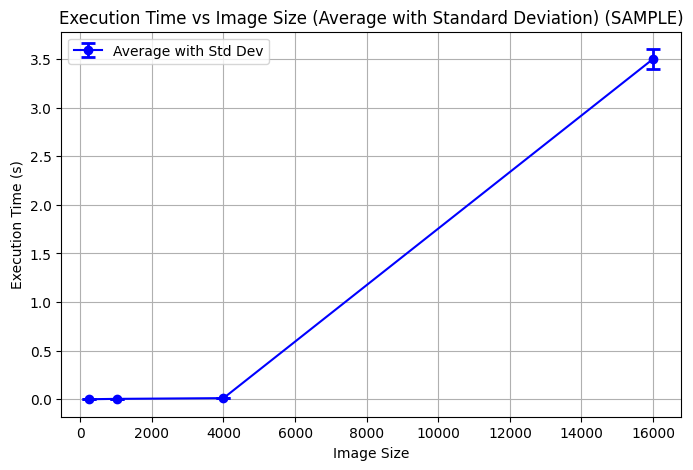

Data with averages and standard deviations:
   image_size  average_time   std_dev
0         256      0.000500  0.000050
1        1024      0.004167  0.000289
2        4000      0.011667  0.001528
3       16000      3.500000  0.100000


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is in a DataFrame called df
# Calculate average and standard deviation
seq_df['average_time'] = seq_df[['run1_time', 'run2_time', 'run3_time']].mean(axis=1)
seq_df['std_dev'] = seq_df[['run1_time', 'run2_time', 'run3_time']].std(axis=1)

# Plot with error bars showing standard deviation
plt.figure(figsize=(8,5))
plt.errorbar(seq_df['image_size'], seq_df['average_time'], 
             yerr=seq_df['std_dev'], 
             marker='o', 
             color='blue', 
             label='Average with Std Dev',
             capsize=5,  # Adds caps to the error bars
             capthick=2,
             elinewidth=2)

plt.xlabel('Image Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Image Size (Average with Standard Deviation) (SAMPLE)')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print the calculated values
print("Data with averages and standard deviations:")
print(seq_df[['image_size', 'average_time', 'std_dev']])

# Part 2: OpenMP Programming

- Use\#pragma omp parallel for collapse(2) for nested loops.
- Experiment with schedule(static) and other scheduling clauses.
- Process large images in tiles (e.g., 512×512 or 1024×1024) to reduce memory bandwidth issues.
- [Bonus Point] Optionally include a blurring step before the Sobel operator to reduce noise. 


#### Question: Explain the algorithm you implemented and if you applyed blurring, explain the blurring method.

#### Your Answer:



In [20]:
omp_df = pd.read_csv("openmp_times.csv")

In [32]:
omp_df.head()

,image_size,threads,run1_time,run2_time,run3_time
0,256,1,0.00050,0.00050,0.00050
1,256,2,0.00045,0.00045,0.00045
2,256,4,0.00040,0.00040,0.00040
3,256,8,0.00030,0.00030,0.00030
4,256,16,0.00025,0.00025,0.00025


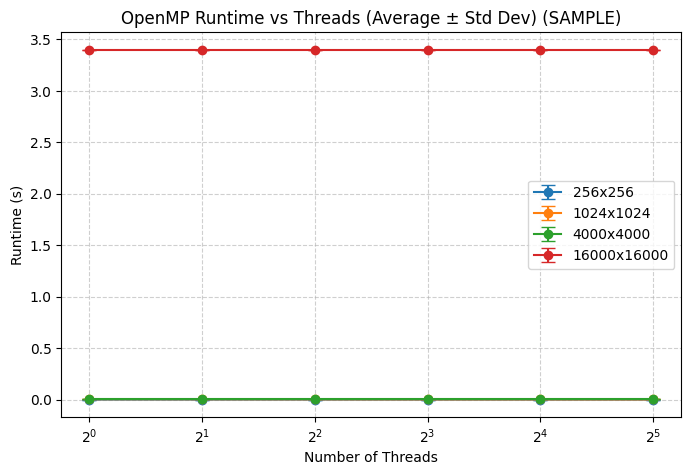

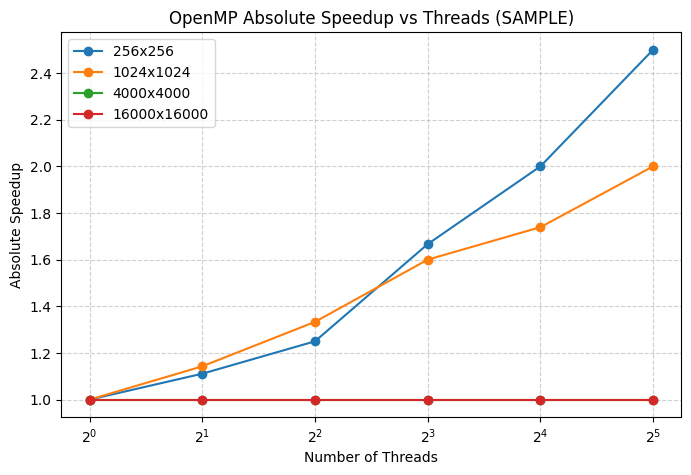

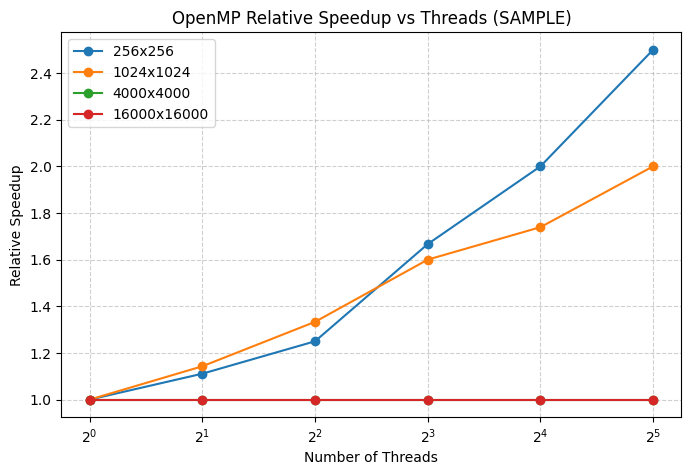

OpenMP data with runtime, std_dev, absolute and relative speedups:
    image_size  threads  average_time       std_dev  absolute_speedup  \
0          256        1       0.00050  0.000000e+00          1.000000   
1          256        2       0.00045  6.639355e-20          1.111111   
2          256        4       0.00040  0.000000e+00          1.250000   
3          256        8       0.00030  0.000000e+00          1.666667   
4          256       16       0.00025  0.000000e+00          2.000000   
5          256       32       0.00020  0.000000e+00          2.500000   
6         1024        1       0.00400  0.000000e+00          1.000000   
7         1024        2       0.00350  0.000000e+00          1.142857   
8         1024        4       0.00300  5.311484e-19          1.333333   
9         1024        8       0.00250  0.000000e+00          1.600000   
10        1024       16       0.00230  0.000000e+00          1.739130   
11        1024       32       0.00200  0.000000e+00      

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV if not already loaded
# omp_df = pd.read_csv("openmp_timings.csv")

# 1️⃣ Compute average and standard deviation across runs
omp_df['average_time'] = omp_df[['run1_time','run2_time','run3_time']].mean(axis=1)
omp_df['std_dev'] = omp_df[['run1_time','run2_time','run3_time']].std(axis=1)

# Prepare columns for speedups
omp_df['absolute_speedup'] = 0.0
omp_df['relative_speedup'] = 0.0

# 2️⃣ Compute absolute and relative speedup
# Absolute speedup: vs sequential execution (threads=1)
# Relative speedup: vs OpenMP 1-thread execution (same in this dataset)
for size in omp_df['image_size'].unique():
    # Sequential time (threads=1)
    seq_time = omp_df[(omp_df['image_size']==size) & (omp_df['threads']==1)]['average_time'].values[0]
    
    subset_idx = omp_df[omp_df['image_size']==size].index
    omp_df.loc[subset_idx, 'absolute_speedup'] = seq_time / omp_df.loc[subset_idx, 'average_time']
    omp_df.loc[subset_idx, 'relative_speedup'] = seq_time / omp_df.loc[subset_idx, 'average_time']

# 3️⃣ Plot runtime with error bars
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size']==size]
    plt.errorbar(subset['threads'], subset['average_time'], 
                 yerr=subset['std_dev'], 
                 marker='o', label=f'{size}x{size}', capsize=5)

plt.xlabel('Number of Threads')
plt.ylabel('Runtime (s)')
plt.title('OpenMP Runtime vs Threads (Average ± Std Dev) (SAMPLE)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 4️⃣ Plot absolute speedup
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size']==size]
    plt.plot(subset['threads'], subset['absolute_speedup'], marker='o', label=f'{size}x{size}')

plt.xlabel('Number of Threads')
plt.ylabel('Absolute Speedup')
plt.title('OpenMP Absolute Speedup vs Threads (SAMPLE)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 5️⃣ Plot relative speedup (same as absolute here)
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size']==size]
    plt.plot(subset['threads'], subset['relative_speedup'], marker='o', label=f'{size}x{size}')

plt.xlabel('Number of Threads')
plt.ylabel('Relative Speedup')
plt.title('OpenMP Relative Speedup vs Threads (SAMPLE)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 6️⃣ Optional: Print the full dataframe
print("OpenMP data with runtime, std_dev, absolute and relative speedups:")
print(omp_df[['image_size','threads','average_time','std_dev','absolute_speedup','relative_speedup']])


# # Part 3: MPI Programming

- Choose a domain decomposition strategy, such as row-wise decomposition, column-wise decomposition, etc., decomposition. Your choice will affect performance, and better-designed decomposition and communication patterns will receive higher marks.
- For each process, you may need to include some approaches to allow seamless computation for the edges.
- [Bonus Point] You can include If a parallelized blurring step and you may need to try to optimize the communications.
- Verify your implementation using small test patterns (5×5 or 10×10) and visually inspect sample images for correctness.


In [36]:
mpi_df = pd.read_csv("mpi_times.csv")

In [37]:
mpi_df.head()

,image_size,nodes,processes,run1_time,run2_time,run3_time
0,256,1,1,0.00050,0.00050,0.00050
1,256,1,2,0.00030,0.00030,0.00030
2,256,1,4,0.00020,0.00020,0.00020
3,256,4,8,0.00015,0.00015,0.00015
4,256,4,16,0.00010,0.00010,0.00010


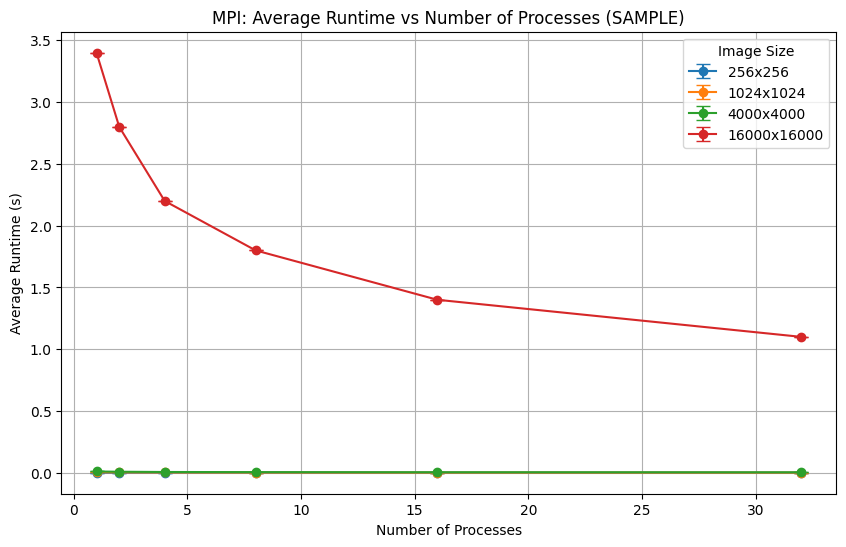

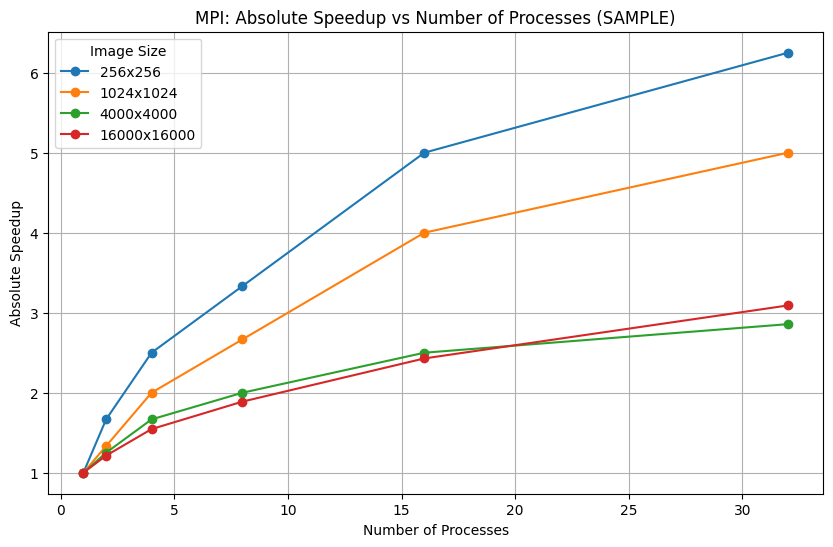

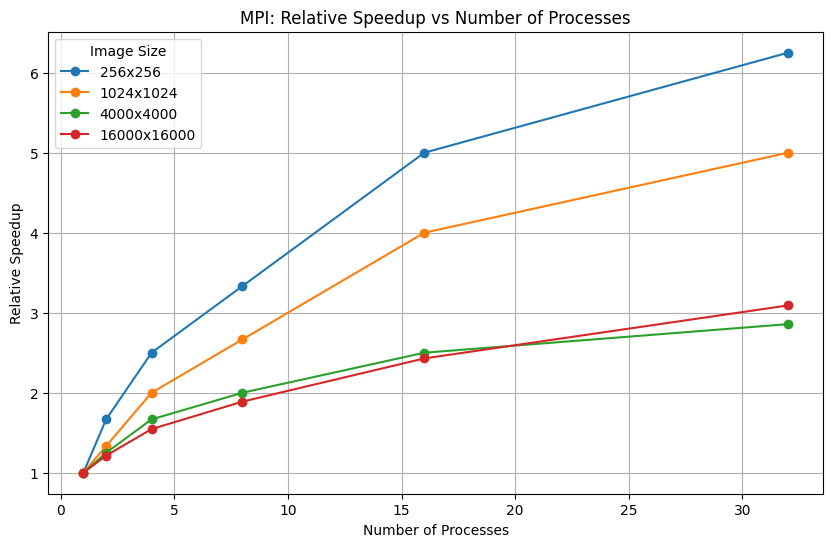

    image_size  nodes  processes  average_time       std_dev  \
0          256      1          1       0.00050  0.000000e+00   
1          256      1          2       0.00030  0.000000e+00   
2          256      1          4       0.00020  0.000000e+00   
3          256      4          8       0.00015  0.000000e+00   
4          256      4         16       0.00010  0.000000e+00   
5          256      4         32       0.00008  0.000000e+00   
6         1024      1          1       0.00400  0.000000e+00   
7         1024      1          2       0.00300  5.311484e-19   
8         1024      1          4       0.00200  0.000000e+00   
9         1024      4          8       0.00150  2.655742e-19   
10        1024      4         16       0.00100  0.000000e+00   
11        1024      4         32       0.00080  0.000000e+00   
12        4000      1          1       0.01000  0.000000e+00   
13        4000      1          2       0.00800  0.000000e+00   
14        4000      1          4       0

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Compute average and standard deviation of runtime
mpi_df['average_time'] = mpi_df[['run1_time', 'run2_time', 'run3_time']].mean(axis=1)
mpi_df['std_dev'] = mpi_df[['run1_time', 'run2_time', 'run3_time']].std(axis=1)

# --- Compute Absolute and Relative Speedup from CSV ---

# Absolute speedup: sequential = 1 process on 1 node
absolute_speedup = {}
for img_size in mpi_df['image_size'].unique():
    # Find sequential runtime: 1 node, 1 process
    seq_time = mpi_df[(mpi_df['image_size']==img_size) & 
                      (mpi_df['nodes']==1) & 
                      (mpi_df['processes']==1)]['average_time'].values[0]
    absolute_speedup[img_size] = seq_time

# Add speedup columns
mpi_df['absolute_speedup'] = mpi_df.apply(lambda row: absolute_speedup[row['image_size']] / row['average_time'], axis=1)

# Relative speedup: 1 process on 1 node runtime as reference
relative_speedup = {}
for img_size in mpi_df['image_size'].unique():
    ref_time = mpi_df[(mpi_df['image_size']==img_size) & 
                      (mpi_df['nodes']==1) & 
                      (mpi_df['processes']==1)]['average_time'].values[0]
    relative_speedup[img_size] = ref_time

mpi_df['relative_speedup'] = mpi_df.apply(lambda row: relative_speedup[row['image_size']] / row['average_time'], axis=1)

# --- Plots ---

# Runtime with error bars
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.errorbar(df_img['processes'], df_img['average_time'], yerr=df_img['std_dev'],
                 marker='o', capsize=5, label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Average Runtime (s)')
plt.title('MPI: Average Runtime vs Number of Processes (SAMPLE)')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# Absolute speedup
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.plot(df_img['processes'], df_img['absolute_speedup'], marker='o', label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Absolute Speedup')
plt.title('MPI: Absolute Speedup vs Number of Processes (SAMPLE)')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# Relative speedup
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.plot(df_img['processes'], df_img['relative_speedup'], marker='o', label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Relative Speedup')
plt.title('MPI: Relative Speedup vs Number of Processes')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# Optional: print dataframe
print(mpi_df[['image_size','nodes','processes','average_time','std_dev','absolute_speedup','relative_speedup']])
